In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cdist
import umap.umap_ as umap
import matplotlib.colors as mcolors

In [2]:
sp_labels_alc1 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K",
    7: "Diamond, 300K",
    8: "Graphite, 300K",
    9: "Graphite, 1500K",
    10: "2.0 gcc, 7000K",
    11: "2.5 gcc, 6000K"
    }

sp_labels_alc2 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "0.5 gcc, 1000K, Bad",
    4: "1.0 gcc, 2000K",
    5: "2.0 gcc, 6000K",
    6: "2.0 gcc, 6000K, Bad",
    7: "3.6 gcc, 6000K",
    8: "3.6 gcc, 6000K, Bad",
    9: "3.0 gcc, 8000K",
    10: "3.0 gcc, 8000K, Bad"
    }

sp_labels_alc3 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad"
    }

sp_labels_alc4 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K"
    }

sp_labels_alc5 = sp_labels_alc4

sp_labels_alc1_pbe = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "2.0 gcc, 6000K, Bad",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad"
    }




In [3]:
with open("2b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("3b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("4b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(58,180)

print(reshaped_data.shape)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

avg_labels = list(range(58))


(58, 180, 1)
(58, 180)


In [4]:
with open("2b_alc_pd.ary", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("3b_alc_pd.ary", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("4b_alc_pd.ary", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open("alc_labels", 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

# Initialize master_array
master_array = None

for index, value in enumerate(pd_2b):
    array_2b = value
    array_3b = pd_3b[index]
    array_4b = pd_4b[index]
    all_array = np.concatenate((array_2b, array_3b, array_4b), axis=1)
    #print(np.shape(all_array))
    # Vertically stack all_array to master_array
    if master_array is None:
        master_array = all_array
    else:
        master_array = np.vstack((master_array, all_array))

# Print shape of the master_array
print("Shape of the master array:", master_array.shape)

all_df = pd.DataFrame(master_array)

Shape of the master array: (1116, 180)


Accuracy: 0.9036544850498339


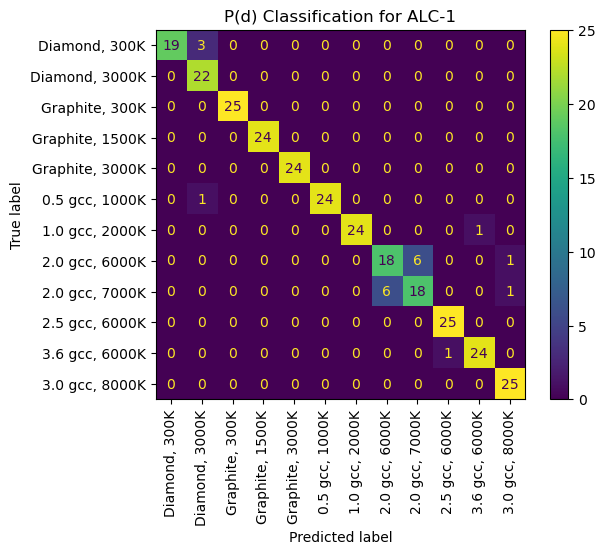

Accuracy: 0.8395061728395061


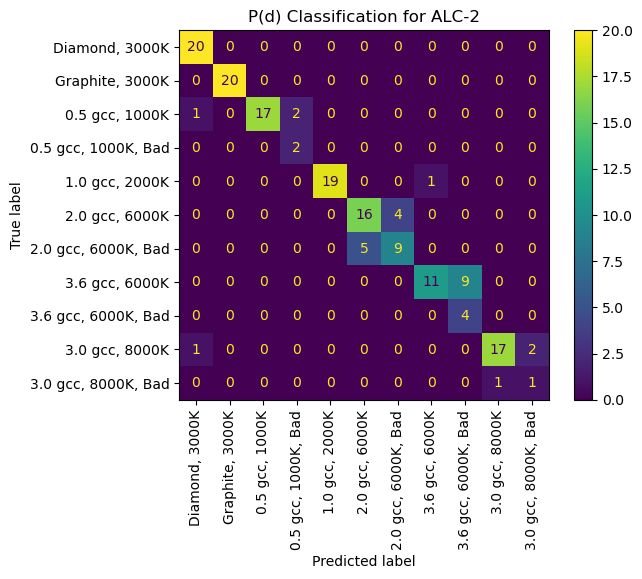

Accuracy: 0.89375


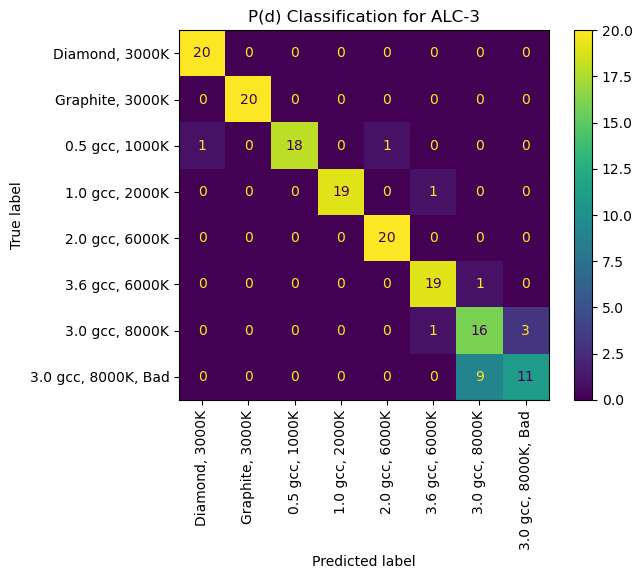

Accuracy: 0.95


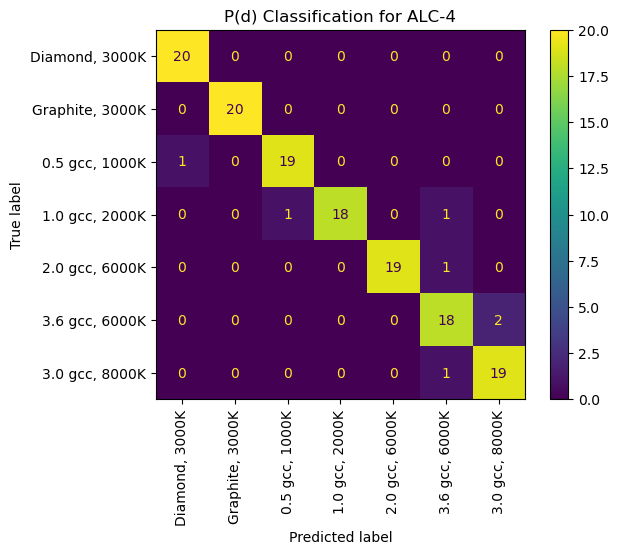

Accuracy: 0.9444444444444444


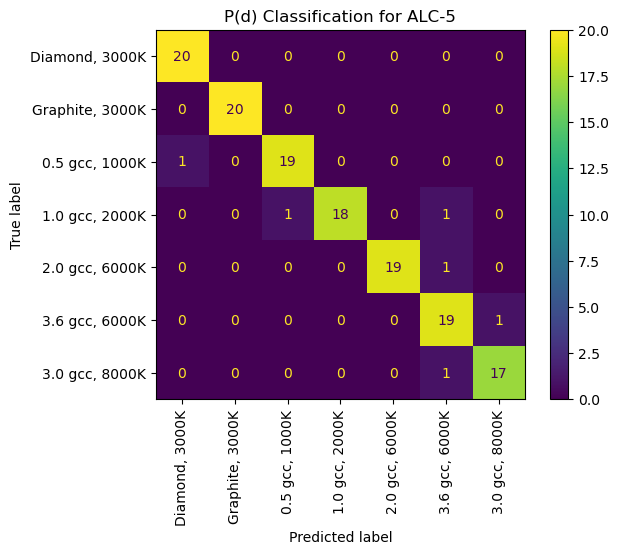

Accuracy: 0.865


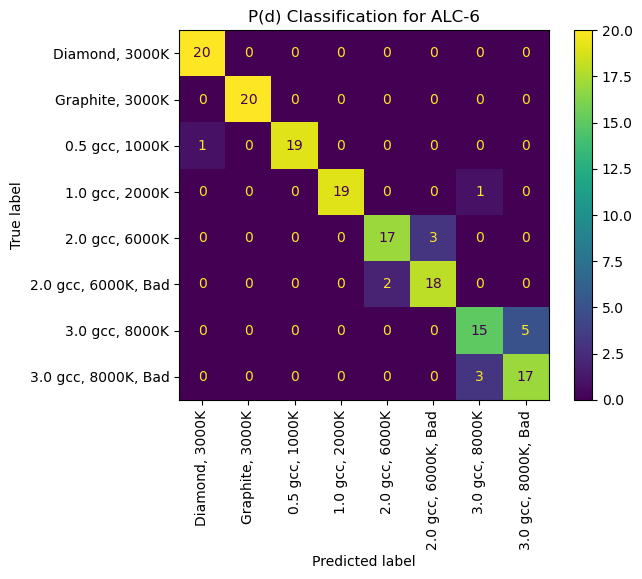

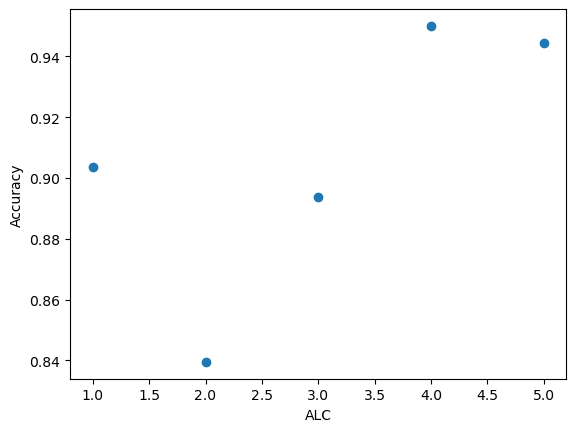

In [5]:
# Define prediction ranges for ALC predictions

# Define Orders for CM
alc1_order = [7, 0, 8, 9, 1, 2, 3, 4, 10, 11, 5, 6]
alc2_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
alc3_order = [0, 1, 2, 3, 4, 5, 6, 7]
alc4_order = [0, 1, 2, 3, 4, 5, 6]
alc5_order = [0, 1, 2, 3, 4, 5, 6]
alc1_pbe_order = [0, 1, 2, 3, 4, 5, 6, 7]

# (start frame, end frame, start sp, end sp)
prediction_ranges = [
    (0, 300, 0, 13, alc1_order, sp_labels_alc1),   # ALC-1
    (310, 471, 14, 24, alc2_order, sp_labels_alc2), # ALC-2
    (472, 631, 25, 32, alc3_order, sp_labels_alc3), # ALC-3
    (632, 771, 33, 39, alc4_order, sp_labels_alc4), # ALC-4
    (772, 915, 40, 47, alc5_order, sp_labels_alc5), # ALC-5
    (916, 1115, 48, 57, alc1_pbe_order, sp_labels_alc1_pbe) # ALC-1 (PBE)
]

alc_cnt = 1
alc_acc = []
alc_master_list = []
master_labels = []

for start_frame, end_frame, start_sp, end_sp, order, sp_labels in prediction_ranges:
    closest_clusters = []
    alc_df = all_df[start_frame:end_frame+1]
    alc_labels = labels[start_frame:end_frame+1]
    alc_avg_df = avg_df[start_sp:end_sp+1]

    for i, row in alc_df.iterrows():
        # Compute distances to all clusters in the original data
        distances_to_clusters = cdist([row], alc_avg_df) # Computes the 2-norm between point and ground truth data
        # Find the index of the closest cluster in the original data
        closest_cluster_index = np.argmin(distances_to_clusters) + start_sp 
        closest_clusters.append(closest_cluster_index)
        master_labels.append(alc_cnt)
    # Compute accuracy
    accuracy = accuracy_score(alc_labels, closest_clusters)
    alc_acc.append(accuracy)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(alc_labels, closest_clusters)
    reordered_cm = cm[order][:, order]
    sorted_sp_labels = {k: sp_labels[k] for k in sorted(sp_labels, key=lambda x: order.index(x))}

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=reordered_cm,
                                  display_labels=[sorted_sp_labels[i] for i in sorted_sp_labels.keys()])
    disp.plot(xticks_rotation=90)
    plt.title(f"P(d) Classification for ALC-{alc_cnt}")
    plt.show()
    alc_cnt +=1
    alc_master_list.append(alc_df)

plt.scatter(list(range(1, alc_cnt-1)),alc_acc[:-1])
plt.xlabel("ALC")
plt.ylabel("Accuracy")
plt.show()


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


1101
1101
1101
1101


/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/2942399541.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 6)  # 'viridis' is the colormap name, and 6 is the number of colors
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/2942399541.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5)


Text(0.5, 1.0, 'UMAP Representation of Data (Equilibrium)')

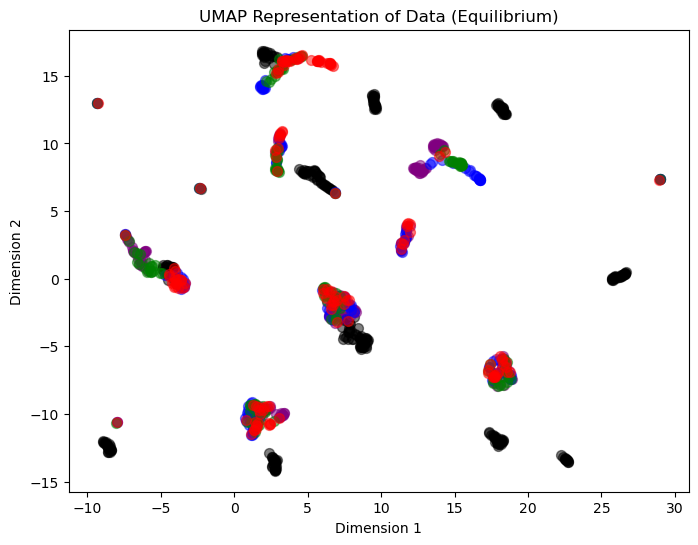

In [6]:
# Vertically stack DataFrames from the master list
stacked_df = pd.concat(alc_master_list, ignore_index=True)
stacked_df["Labels"] = master_labels
removedna_df = stacked_df.dropna()
cleaned_labels = removedna_df["Labels"]
removed_labels = removedna_df.drop(columns=["Labels"])

umap_model = umap.UMAP(random_state=42, n_components=2, n_neighbors=10, min_dist=0.3)
embedding = umap_model.fit_transform(removed_labels)
print(len(embedding))
print(len(removedna_df))
print(len(cleaned_labels))
print(len(removed_labels))

# Plot the embedded data with colors and shapes based on labels
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# # Define the number of unique labels
# #num_labels = len(avg_labels)
# num_labels=12
# # Create a colormap using the 'hsv' colormap
# color_map = [mcolors.hsv_to_rgb([i / num_labels, 1, 1]) for i in range(num_labels)]

# shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    # Add more shapes if needed
# Define a colormap

cmap = plt.cm.get_cmap('viridis', 6)  # 'viridis' is the colormap name, and 6 is the number of colors

# Numbers to assign colors to (assuming a range from 1 to 6)
numbers = [1, 2, 3, 4, 5, 6]

# Assign colors to numbers
colors = [cmap(i) for i in range(6)]
# Determine the min and max values of the label data
label_min = cleaned_labels.min()
label_max = cleaned_labels.max()
# Plot points based on closest clusters
for i in range(len(removed_labels)):
    x, y = embedding[i]  # Coordinates of the point
    label = int(cleaned_labels.iloc[i])
    if label == 1:
        color = "black"
    elif label == 2:
        color = "purple"
    elif label == 3:
        color = "blue"
    elif label == 4:
        color = "green"
        #continue
    elif label == 5:
        color = "red"
        #continue
    else:
        continue
    plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5)

# Add colorbar to show the mapping from index to color
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP Representation of Data (Equilibrium)')



/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

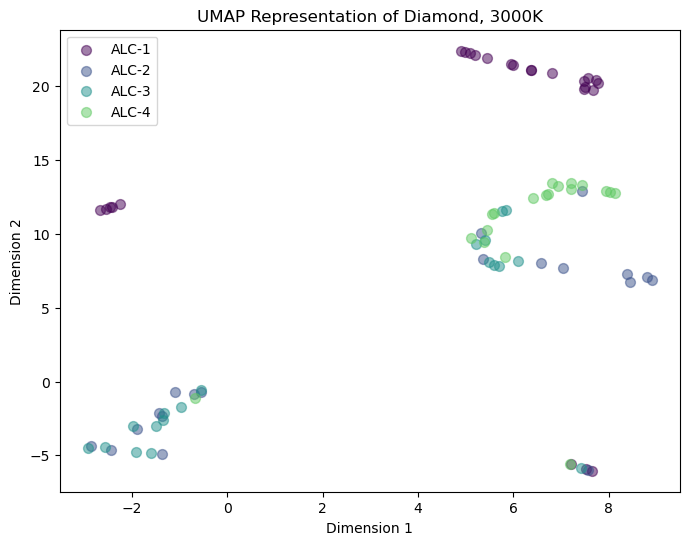

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

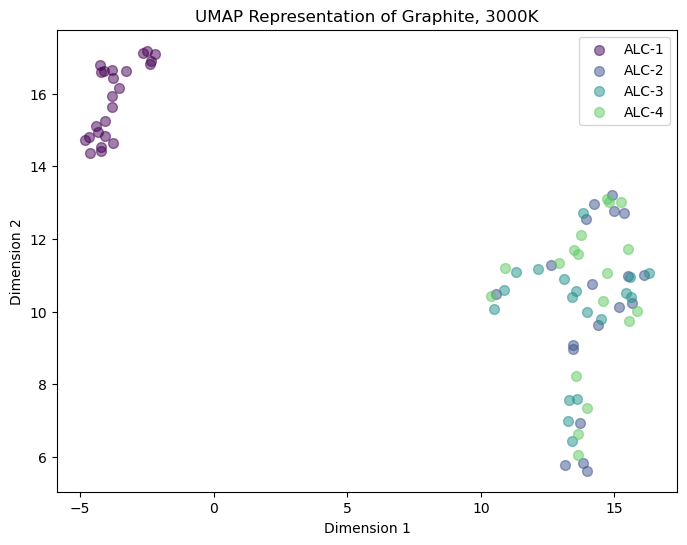

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

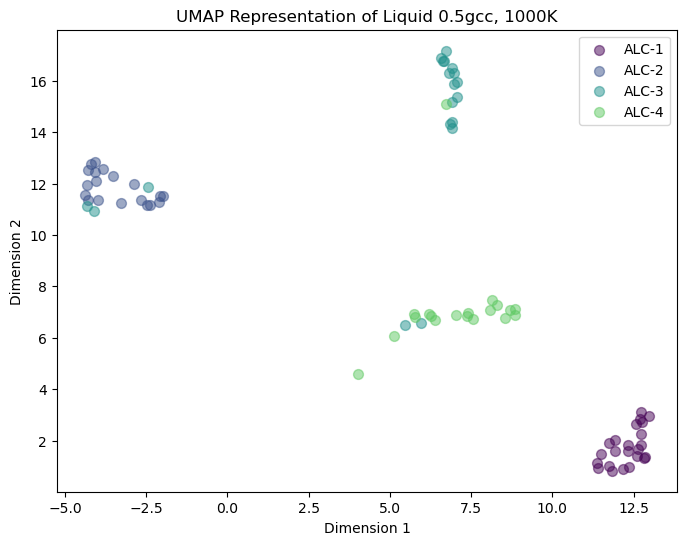

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

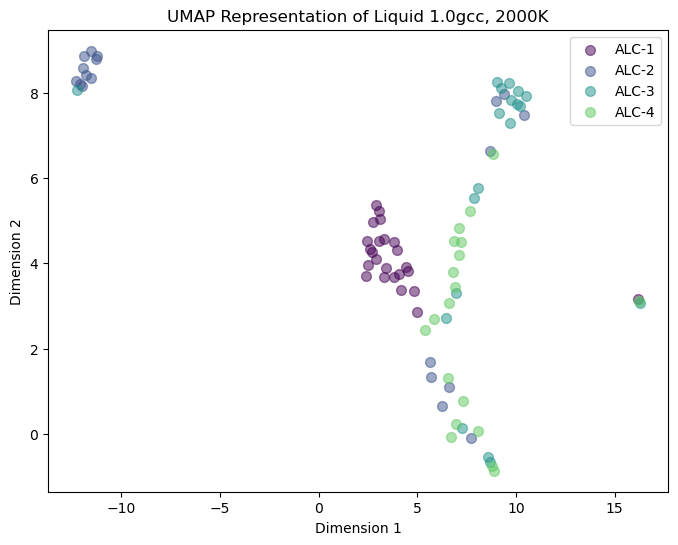

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

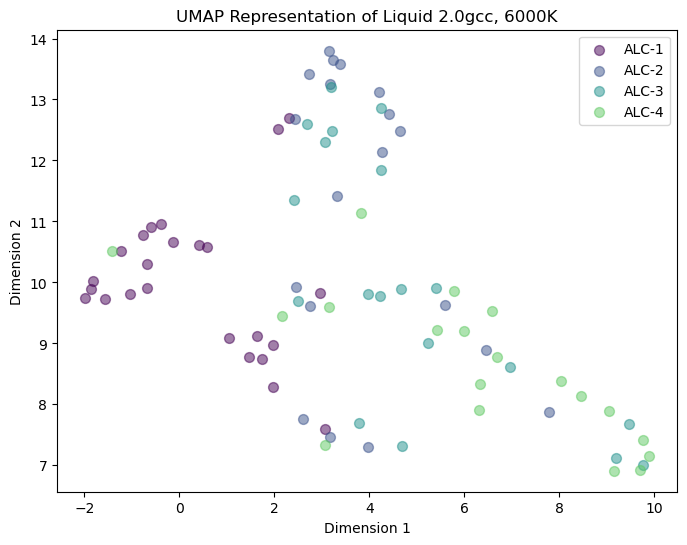

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

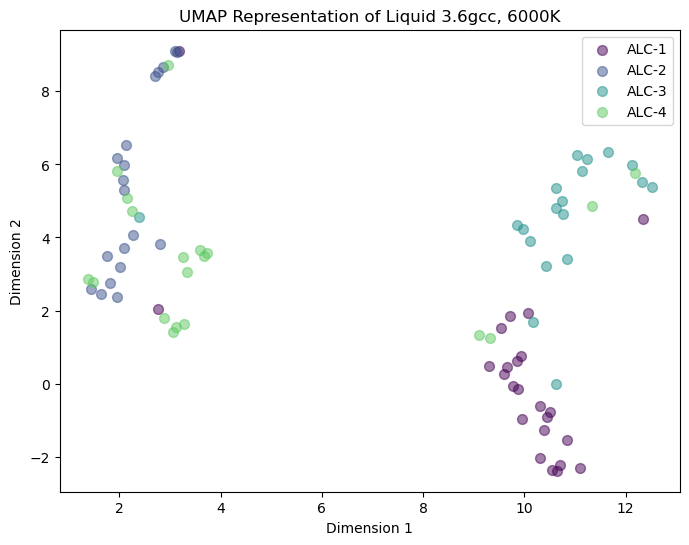

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/1483327943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

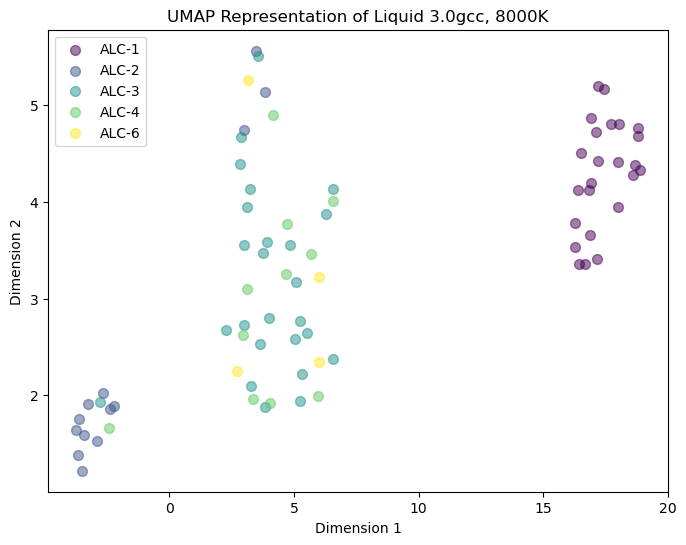

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap

# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted
    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])
        if label == 5:  # Skip label 5
            continue

        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (5 - 1)

        # Use the normalized label value as the color
        color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
        else:
            plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()

# Function to process and plot data
def process_and_plot_data(data, labels, title):
    # Vertically stack DataFrames from the master list
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]
    removed_labels = removedna_df.drop(columns=["Labels"])

    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=5, min_dist=0.2)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, title)

# Define your datasets and labels
diamonds_data = [
    alc_master_list[0][:25], alc_master_list[1][:20], alc_master_list[2][:20],
    alc_master_list[3][:20], alc_master_list[4][:20]
]
diamonds_labels = [
    pd.DataFrame(master_labels[:25]), pd.DataFrame(master_labels[310:329]),
    pd.DataFrame(master_labels[472:491]), pd.DataFrame(master_labels[632:651]),
    pd.DataFrame(master_labels[772:791])
]

graphite_data = [
    alc_master_list[0][25:49], alc_master_list[1][21:41], alc_master_list[2][21:41],
    alc_master_list[3][21:41], alc_master_list[4][21:41]
]
graphite_labels = [
    pd.DataFrame(master_labels[25:49]), pd.DataFrame(master_labels[330:349]),
    pd.DataFrame(master_labels[492:511]), pd.DataFrame(master_labels[652:671]),
    pd.DataFrame(master_labels[792:811])
]

liquid_05_1000K_data = [
    alc_master_list[0][50:74], alc_master_list[1][41:61], alc_master_list[2][41:61],
    alc_master_list[3][41:61], alc_master_list[4][41:61]
]
liquid_05_1000K_labels = [
    pd.DataFrame(master_labels[50:74]), pd.DataFrame(master_labels[350:369]),
    pd.DataFrame(master_labels[512:531]), pd.DataFrame(master_labels[672:691]),
    pd.DataFrame(master_labels[812:831])
]

liquid_10_2000K_data = [
    alc_master_list[0][75:99], alc_master_list[1][63:73], alc_master_list[2][61:81],
    alc_master_list[3][61:81], alc_master_list[4][61:81]
]
liquid_10_2000K_labels = [
    pd.DataFrame(master_labels[75:99]), pd.DataFrame(master_labels[372:391]),
    pd.DataFrame(master_labels[532:551]), pd.DataFrame(master_labels[692:711]),
    pd.DataFrame(master_labels[832:851])
]

liquid_20_6000K_data = [
    alc_master_list[0][100:124], alc_master_list[1][83:103], alc_master_list[2][81:101],
    alc_master_list[3][81:101], alc_master_list[4][81:101]
]
liquid_20_6000K_labels = [
    pd.DataFrame(master_labels[100:124]), pd.DataFrame(master_labels[392:411]),
    pd.DataFrame(master_labels[552:571]), pd.DataFrame(master_labels[712:731]),
    pd.DataFrame(master_labels[852:871])
]

liquid_36_6000K_data = [
    alc_master_list[0][125:149], alc_master_list[1][116:136], alc_master_list[2][101:121],
    alc_master_list[3][101:121], alc_master_list[4][101:121]
]
liquid_36_6000K_labels = [
    pd.DataFrame(master_labels[125:149]), pd.DataFrame(master_labels[426:445]),
    pd.DataFrame(master_labels[572:591]), pd.DataFrame(master_labels[732:751]),
    pd.DataFrame(master_labels[872:891])
]

liquid_30_8000K_data = [
    alc_master_list[0][150:174], alc_master_list[1][141:161], alc_master_list[2][121:141],
    alc_master_list[3][121:141], alc_master_list[4][121:141]
]
liquid_30_8000K_labels = [
    pd.DataFrame(master_labels[125:149]), pd.DataFrame(master_labels[450:469]),
    pd.DataFrame(master_labels[592:611]), pd.DataFrame(master_labels[752:771]),
    pd.DataFrame(master_labels[892:911])
]

# Process and plot data
process_and_plot_data(diamonds_data, diamonds_labels, 'UMAP Representation of Diamond, 3000K')
process_and_plot_data(graphite_data, graphite_labels, 'UMAP Representation of Graphite, 3000K')
process_and_plot_data(liquid_05_1000K_data, liquid_05_1000K_labels, 'UMAP Representation of Liquid 0.5gcc, 1000K')
process_and_plot_data(liquid_10_2000K_data, liquid_10_2000K_labels, 'UMAP Representation of Liquid 1.0gcc, 2000K')
process_and_plot_data(liquid_20_6000K_data, liquid_20_6000K_labels, 'UMAP Representation of Liquid 2.0gcc, 6000K')
process_and_plot_data(liquid_36_6000K_data, liquid_36_6000K_labels, 'UMAP Representation of Liquid 3.6gcc, 6000K')
process_and_plot_data(liquid_30_8000K_data, liquid_30_8000K_labels, 'UMAP Representation of Liquid 3.0gcc, 8000K')


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/2616111021.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_54258/2616111021.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='viridis', s=5

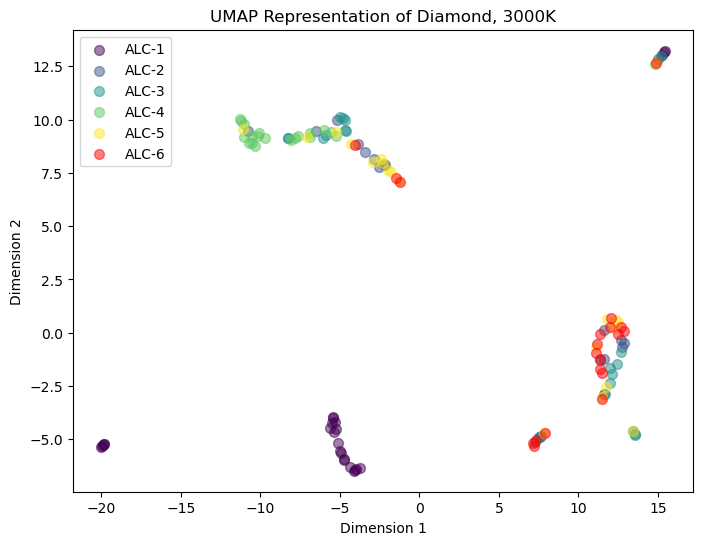

In [119]:

# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])

        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (5 - 1)

        # Determine color
        if label == 6:
            color = "red"
        else:
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5, label=f"ALC-{label}")
        else:
            plt.scatter(x, y, c=color, cmap='viridis', s=50, alpha=0.5)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title):
   # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=5, min_dist=0.2)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, title)

# Read the CSV file into a DataFrame
df = pd.read_csv('Carbon_data_defs.csv', header=1)
df = df[:58]

# Filter rows where the 'phase' column is equal to 'diamond'
diamond_rows = df[(df['phase'] == 'diamond') & (df['T'] == 3000)]

# Define your datasets and labels
diamonds_data = [
    alc_master_list[0][:int(diamond_rows.iloc[0]["Total frames"])], 
    alc_master_list[1][:int(diamond_rows.iloc[1]["Total frames"])], 
    alc_master_list[2][:int(diamond_rows.iloc[2]["Total frames"])],
    alc_master_list[3][:int(diamond_rows.iloc[3]["Total frames"])], 
    alc_master_list[4][:int(diamond_rows.iloc[4]["Total frames"])],
    alc_master_list[5][:int(diamond_rows.iloc[5]["Total frames"])],
]

diamonds_labels = []

# Iterate through each row in diamond_rows
for index, row in diamond_rows.iterrows():
    # Extract the start and end frames
    length = int(row["Total frames"])
    value = int(row["Eff ALC"])
    # Create the array
    array = pd.DataFrame(np.full(length, value))
    diamonds_labels.append(array)

process_and_plot_data(diamonds_data, diamonds_labels, 'UMAP Representation of Diamond, 3000K')

